# Features only copy

In [1]:
import pandas as pd
import numpy as np


from io import StringIO
import requests
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.simplefilter('ignore')


from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


### instance_commname

- us-east-1	  US East (N. Virginia)
- us-east-2   US East (Ohio)
- us-west-1	  US West (N. California)
- us-west-2	  US West (Oregon)

In [2]:
path_feat = r'/Users/Yejur/Documents/GitHub/Capstone/Data_feat'

In [3]:
uswest_ore_west2 = pd.read_csv(path_feat + '/Amazon EC2 Instance Comparison_WEST_OREGAN.csv', low_memory=False)
uswest_cal_west1 = pd.read_csv(path_feat + '/Amazon EC2 Instance Comparison_WEST_NCALI.csv', low_memory=False)
useast_ohi_east2 = pd.read_csv(path_feat + '/Amazon EC2 Instance Comparison_EAST_OHIO.csv', low_memory=False)
useast_vir_east1 = pd.read_csv(path_feat + '/Amazon EC2 Instance Comparison_EAST_NVIRGINIA.csv', low_memory=False)

In [4]:
uswest_ore_west2['AvailabilityZone'] = 'us-west-2'
uswest_cal_west1['AvailabilityZone'] = 'us-west-1'
useast_ohi_east2['AvailabilityZone'] = 'us-east-2'
useast_vir_east1['AvailabilityZone'] = 'us-east-1'

In [5]:
print(uswest_ore_west2.shape)
print(uswest_cal_west1.shape)
print(useast_ohi_east2.shape)
print(useast_vir_east1.shape)

(200, 53)
(200, 53)
(200, 53)
(200, 53)


In [6]:
instances_info_all = pd.concat([uswest_ore_west2,uswest_cal_west1,useast_ohi_east2,useast_vir_east1])

In [7]:
print(instances_info_all['API Name'].nunique())
print(instances_info_all.shape)

200
(800, 53)


In [8]:
instances_info = instances_info_all[['AvailabilityZone','API Name', 'Memory', 'vCPUs', 'GPUs',
                                     'Linux On Demand cost', 'Linux Reserved cost',  'Windows On Demand cost', 
                                     'Windows Reserved cost']]

In [9]:
instances_info['Memory'] = instances_info['Memory'].str.replace('GiB', '').str.strip()
instances_info['vCPUs'] = instances_info['vCPUs'].str[:3].str.replace('v','').str.strip()
instances_info['Linux On Demand cost'] = instances_info['Linux On Demand cost'].str.replace('hourly','').str.strip()
instances_info['Linux On Demand cost'] = instances_info['Linux On Demand cost'].str.replace('$','').str.strip()
instances_info['Linux Reserved cost'] = instances_info['Linux Reserved cost'].str.replace('hourly','').str.strip()
instances_info['Linux Reserved cost'] = instances_info['Linux Reserved cost'].str.replace('$','').str.strip()
instances_info['Windows On Demand cost'] = instances_info['Windows On Demand cost'].str.replace('hourly','').str.strip()
instances_info['Windows On Demand cost'] = instances_info['Windows On Demand cost'].str.replace('$','').str.strip()
instances_info['Windows Reserved cost'] = instances_info['Windows Reserved cost'].str.replace('hourly','').str.strip()
instances_info['Windows Reserved cost'] = instances_info['Windows Reserved cost'].str.replace('$','').str.strip()

In [10]:
instances_info = instances_info.replace('unavailable',np.nan)

In [11]:
instances_info.head()

,AvailabilityZone,API Name,Memory,vCPUs,GPUs,Linux On Demand cost,Linux Reserved cost,Windows On Demand cost,Windows Reserved cost
0,us-west-2,a1.medium,2.0,1,0,0.025500,0.016100,NaN,NaN
1,us-west-2,t3a.xlarge,16.0,4,0,0.150400,0.094300,0.224000,0.167900
2,us-west-2,r4.16xlarge,488.0,64,0,4.256000,2.688000,7.200000,5.632000
3,us-west-2,t2.large,8.0,2,0,0.092800,0.057500,0.120800,0.085500
4,us-west-2,m5a.24xlarge,384.0,96,0,4.128000,2.627000,8.544000,7.043000


In [12]:
ren_columns =['Zone','InstanceType', 'Memory', 'vCPUs', 'GPUs','linux_ondemand', 'linux_reserved', 'windows_ondemand','windows_reserved']
instances_info.columns= ren_columns
instances_info.sample(2)

,Zone,InstanceType,Memory,vCPUs,GPUs,linux_ondemand,linux_reserved,windows_ondemand,windows_reserved
87,us-west-2,m5a.4xlarge,64.0,16,0,0.688000,0.438000,1.424000,1.174000
52,us-west-2,h1.8xlarge,128.0,32,0,1.872000,1.272000,3.344000,2.744000


# DATA

In [13]:
# %time
# url="https://s3-us-west-2.amazonaws.com/aws-spot-prices/SpotPrices/ap-northeast-1.csv"
# s=requests.get(url).text
# nw_data=pd.read_csv(StringIO(s), low_memory=False, header=None)
# nw_data.columns = ['Date_Time', 'Instance', 'OS', 'Region', 'Spot_Price']
# nw_data.head()
unzip_path = r'/Users/Yejur/Documents/GitHub/Capstone/AWS_Spot_Prices' 
east_1 = pd.read_csv(unzip_path + '/us-east-1.csv', error_bad_lines=False,low_memory=False)
east_2 = pd.read_csv(unzip_path + '/us-east-2.csv',error_bad_lines=False,low_memory=False)
west_1 = pd.read_csv(unzip_path + '/us-west-1.csv', error_bad_lines=False,low_memory=False)
west_2 = pd.read_csv(unzip_path + '/us-west-2.csv', error_bad_lines=False,low_memory=False)

b'Skipping line 164001: expected 5 fields, saw 9\n'


In [14]:
west_2['Zone'] = 'us-west-2'
west_1['Zone'] = 'us-west-1'
east_2['Zone'] = 'us-east-2'
east_1['Zone'] = 'us-east-1'

In [15]:
west_2.ProductDescription.unique()

array(['SUSE Linux', 'Linux/UNIX', 'Windows'], dtype=object)

In [16]:
main_data = pd.concat([east_1,east_2,west_1,west_2])

In [17]:
main_data.shape

(634013, 6)

In [18]:
main_data.sample(2)

,AvailabilityZone,InstanceType,Price,ProductDescription,Timestamp,Zone
122288,us-east-1b,z1d.large,0.2860,SUSE Linux,5/6/19 1:18,us-east-1
67415,us-west-2a,m5a.2xlarge,0.1374,Linux/UNIX,5/9/19 8:44:22 PM,us-west-2


In [19]:
main_data.ProductDescription.unique()

array(['SUSE Linux', 'Linux/UNIX', 'Windows'], dtype=object)

# Other features

In [26]:
us_east_1_windows = pd.read_clipboard(header=None)

In [50]:
us_east_1_windows.shape

(169, 7)

In [48]:
us_east_1_windows['os']='Windows'
us_east_1_windows['Zone']='us-east-1'

In [29]:
us_east_1_linux = pd.read_clipboard(header=None)

In [30]:
us_east_1_linux.shape

(184, 5)

In [51]:
us_east_1_linux['os']='Linux/UNIX'
us_east_1_linux['Zone']='us-east-1'

In [31]:
us_east_2_linux = pd.read_clipboard(header=None)

In [32]:
us_east_2_linux.shape

(142, 5)

In [52]:
us_east_2_linux['os']='Linux/UNIX'
us_east_2_linux['Zone']='us-east-2'

In [33]:
us_east_2_windows = pd.read_clipboard(header=None)

In [34]:
us_east_2_windows.shape

(128, 5)

In [53]:
us_east_2_windows['os']='Windows'
us_east_2_windows['Zone']='us-east-2'

In [35]:
us_west_1_linux = pd.read_clipboard(header=None)

In [36]:
us_west_1_linux.shape

(118, 5)

In [54]:
us_west_1_linux['os']='Linux/UNIX'
us_west_1_linux['Zone']='us-west-1'

In [37]:
us_west_1_windows = pd.read_clipboard(header=None)

In [38]:
us_west_1_windows.shape

(105, 5)

In [55]:
us_west_1_windows['os']='Windows'
us_west_1_windows['Zone']='us-west-1'

In [39]:
us_west_2_linux = pd.read_clipboard(header=None)

In [40]:
us_west_2_linux.shape

(182, 5)

In [56]:
us_west_2_linux['os']='Linux/UNIX'
us_west_2_linux['Zone']='us-west-2'

In [41]:
us_west_2_windows = pd.read_clipboard(header=None)

In [42]:
us_west_2_windows.shape

(162, 5)

In [57]:
us_west_2_windows['os']='Windows'
us_west_2_windows['Zone']='us-west-2'

In [58]:
us_west_2_windows.sample(2)

,0,1,2,3,4,os,Zone
93,r3.4xlarge,16,122.0,55%,<5%,Windows,us-west-2
48,m2.4xlarge,8,68.4,66%,<5%,Windows,us-west-2


In [63]:
col_f_con = ['InstanceType', 'vCPU', 'memory', 'savings_on_demand', 'freq_interruption', 'os', 'zone']

In [59]:
all_new_feat = pd.concat([us_east_1_windows,us_east_1_linux,us_east_2_linux,us_east_2_windows,
                         us_west_1_linux,us_west_1_windows,us_west_2_linux,us_west_2_windows])

In [61]:
all_new_feat.shape

(1190, 7)

In [64]:
all_new_feat.columns = col_f_con
all_new_feat.head()

,InstanceType,vCPU,memory,savings_on_demand,freq_interruption,os,zone
0,c1.medium,2,1.70,56%,<5%,Windows,us-east-1
1,c1.xlarge,8,7.00,56%,>20%,Windows,us-east-1
2,c3.large,2,3.75,40%,<5%,Windows,us-east-1
3,c3.xlarge,4,7.50,40%,<5%,Windows,us-east-1
4,c3.2xlarge,8,15.00,40%,<5%,Windows,us-east-1


In [65]:
all_new_feat.to_csv('new_feat.csv', index=False)

In [20]:
new_feat = pd.read_csv('new_feat.csv', low_memory=False)

In [21]:
new_feat['savings_on_demand'] = new_feat['savings_on_demand'].str.replace('%','').str.strip()

In [22]:
new_feat['interrupt_freq'] = pd.Categorical(new_feat['freq_interruption']).codes
# new_feat['freq_interruption'].unique()

In [23]:
new_feat[['freq_interruption', 'interrupt_freq']].drop_duplicates()

,freq_interruption,interrupt_freq
0,<5%,3
1,>20%,4
9,5-10%,2
12,10-15%,0
13,15-20%,1


In [24]:
new_feat.sample(2)

,InstanceType,vCPU,memory,savings_on_demand,freq_interruption,os,zone,interrupt_freq
194,c5d.2xlarge,8,16.0,63,>20%,Linux/UNIX,us-east-1,4
520,d2.4xlarge,16,122.0,63,>20%,Windows,us-east-2,4


In [25]:
new_feat = new_feat.rename(columns={'os':'ProductDescription','zone':'Zone'})

In [26]:
new_feat.sample(2)

,InstanceType,vCPU,memory,savings_on_demand,freq_interruption,ProductDescription,Zone,interrupt_freq
1189,z1d.metal,48,384.0,47,>20%,Windows,us-west-2,4
371,c5d.2xlarge,8,16.0,80,5-10%,Linux/UNIX,us-east-2,2


In [27]:
main_data.sample(2)

,AvailabilityZone,InstanceType,Price,ProductDescription,Timestamp,Zone
145885,us-west-2a,r5.metal,1.1333,Linux/UNIX,4/14/19 7:37:08 PM,us-west-2
82857,us-east-2a,m5a.24xlarge,6.1735,Windows,4/2/19 13:52,us-east-2


In [28]:
main_data_tets = main_data.merge(new_feat, how='left', on=['InstanceType', 'Zone', 'ProductDescription'])

In [29]:
main_data_tets.shape

(634013, 11)

In [30]:
main_data_tets.sample(2)

,AvailabilityZone,InstanceType,Price,ProductDescription,Timestamp,Zone,vCPU,memory,savings_on_demand,freq_interruption,interrupt_freq
410323,us-west-1c,m1.small,0.0047,Linux/UNIX,4/19/19 7:40,us-west-1,1.0,1.7,90,<5%,3.0
283900,us-east-2c,r4.16xlarge,0.6912,Linux/UNIX,5/20/19 12:57,us-east-2,64.0,488.0,82,>20%,4.0


In [31]:
main_data_tets.columns

Index(['AvailabilityZone', 'InstanceType', 'Price', 'ProductDescription',
       'Timestamp', 'Zone', 'vCPU', 'memory', 'savings_on_demand',
       'freq_interruption', 'interrupt_freq'],
      dtype='object')

In [32]:
# main_data_tets
# linux_full_dataset['AvailabilityZone_code'] = pd.Categorical(linux_full_dataset['AvailabilityZone']).codes
# linux_full_dataset['InstanceType_code'] = pd.Categorical(linux_full_dataset['InstanceType']).codes

In [33]:
clean_main = main_data_tets[['Timestamp','InstanceType', 'ProductDescription','Zone', 
                'vCPU', 'memory', 'savings_on_demand', 
                'interrupt_freq','Price']].drop_duplicates()

In [34]:
clean_main =clean_main[clean_main['ProductDescription']!='SUSE Linux']

In [35]:
clean_main.shape

(279059, 9)

In [36]:
clean_main.InstanceType.nunique()

193

In [37]:
clean_main.sample(2)

,Timestamp,InstanceType,ProductDescription,Zone,vCPU,memory,savings_on_demand,interrupt_freq,Price
451629,5/26/19 1:47:35 AM,m5d.2xlarge,Linux/UNIX,us-west-2,8.0,32.0,69,4.0,0.1386
114276,5/7/19 19:07,m4.16xlarge,Windows,us-east-1,64.0,256.0,35,3.0,3.9804


In [38]:
clean_main['Timestamp'] = clean_main['Timestamp'].astype(np.datetime64)
clean_main['Zone_code'] = pd.Categorical(clean_main['Zone']).codes
clean_main['InstanceType_code'] = pd.Categorical(clean_main['InstanceType']).codes

In [39]:
clean_main['os_code'] = pd.Categorical(clean_main['ProductDescription']).codes

In [40]:
clean_main.columns

Index(['Timestamp', 'InstanceType', 'ProductDescription', 'Zone', 'vCPU',
       'memory', 'savings_on_demand', 'interrupt_freq', 'Price', 'Zone_code',
       'InstanceType_code', 'os_code'],
      dtype='object')

In [41]:
clean_main_allinalgo = clean_main[['Timestamp', 'os_code', 'vCPU','memory', 
                                   'savings_on_demand', 'interrupt_freq',  
                                   'Zone_code','InstanceType_code','Price']]

In [42]:
clean_main_allinalgo.sample(2)

,Timestamp,os_code,vCPU,memory,savings_on_demand,interrupt_freq,Zone_code,InstanceType_code,Price
83332,2019-05-14 04:20:00,0,16.0,122.0,67,3.0,0,58,0.4225
550317,2019-04-24 13:04:30,0,24.0,192.0,70,2.0,3,189,0.7478


In [44]:
clean_main_allinalgo_1 = clean_main_allinalgo.sort_values(by='Timestamp')

In [45]:
clean_main_allinalgo_1.to_csv('alternative_dataset.csv', index=False)

In [46]:
model_feat = pd.read_csv('alternative_dataset.csv', low_memory=False)

# Combining and merging info with main data

In [94]:
# main_data_1 = main_data.pivot_table(index= ['Timestamp','AvailabilityZone','InstanceType','Zone'],
#                                     columns=['ProductDescription'],  values=['Price']).reset_index()

In [96]:
# main_data_1

In [21]:
# main_data_2 = main_data_1.merge(instances_info, how='left', on=['InstanceType','Zone'])

In [97]:
# main_data_2.columns

In [23]:
# columns_proper = [ 'InstanceType','Zone','Timestamp','AvailabilityZone','InstanceType_1', 'Zone_1','Price_Linux/UNIX', 'Price_SUSE Linux',
#                   'Price_Windows', 'Memory','vCPUs', 'GPUs','Cost_linux_ondemand','Cost_linux_reserved','Cost_windows_ondemand',
#                   'Cost_windows_reserved']

In [98]:
# main_data_2.columns = columns_proper
# main_data_2.head()

In [99]:
# linux_full_dataset = main_data_2[['InstanceType','Zone','Timestamp','AvailabilityZone','Price_Linux/UNIX',
#                                   'Memory','vCPUs', 'GPUs','Cost_linux_ondemand','Cost_linux_reserved']]

# windows_full_dataset = main_data_2[['InstanceType','Zone','Timestamp','AvailabilityZone','Price_Windows',
#                                   'Memory','vCPUs', 'GPUs','Cost_windows_ondemand','Cost_windows_reserved']]

In [100]:
# windows_full_dataset.info()

In [101]:
# linux_full_dataset.info()

In [102]:
# linux_full_dataset[['Cost_linux_ondemand','Cost_linux_reserved']]=linux_full_dataset[['Cost_linux_ondemand','Cost_linux_reserved']].astype(np.float)

In [29]:
windows_full_dataset[['Cost_windows_ondemand','Cost_windows_reserved']]=windows_full_dataset[['Cost_windows_ondemand','Cost_windows_reserved']].astype(np.float)

In [30]:
linux_full_dataset['Timestamp'] = linux_full_dataset['Timestamp'].astype(np.datetime64)
windows_full_dataset['Timestamp'] = windows_full_dataset['Timestamp'].astype(np.datetime64)

In [31]:
# CHECKPOINT
# writing file for checkpointing
linux_full_dataset.to_csv('linux_data_clean.csv', index=False)
windows_full_dataset.to_csv('windows_data_clean.csv', index=False)

In [32]:
windows_full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363326 entries, 0 to 363325
Data columns (total 10 columns):
InstanceType             363326 non-null object
Zone                     363326 non-null object
Timestamp                363326 non-null datetime64[ns]
AvailabilityZone         363326 non-null object
Price_Windows            163323 non-null float64
Memory                   363326 non-null object
vCPUs                    363326 non-null object
GPUs                     363326 non-null int64
Cost_windows_ondemand    358004 non-null float64
Cost_windows_reserved    358004 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 30.5+ MB


In [33]:
linux_full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363326 entries, 0 to 363325
Data columns (total 10 columns):
InstanceType           363326 non-null object
Zone                   363326 non-null object
Timestamp              363326 non-null datetime64[ns]
AvailabilityZone       363326 non-null object
Price_Linux/UNIX       261253 non-null float64
Memory                 363326 non-null object
vCPUs                  363326 non-null object
GPUs                   363326 non-null int64
Cost_linux_ondemand    363138 non-null float64
Cost_linux_reserved    362655 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 30.5+ MB


In [34]:
windows_full_dataset.head()

,InstanceType,Zone,Timestamp,AvailabilityZone,Price_Windows,Memory,vCPUs,GPUs,Cost_windows_ondemand,Cost_windows_reserved
0,r5ad.4xlarge,us-east-1,2019-03-30 22:00:03,us-east-1f,NaN,128.0,16,0,1.784,1.400
1,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1a,1.0081,64.0,16,0,1.640,1.312
2,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1b,1.0081,64.0,16,0,1.640,1.312
3,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1c,1.0081,64.0,16,0,1.640,1.312
4,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1d,1.0081,64.0,16,0,1.640,1.312


In [35]:
linux_full_dataset.head()

,InstanceType,Zone,Timestamp,AvailabilityZone,Price_Linux/UNIX,Memory,vCPUs,GPUs,Cost_linux_ondemand,Cost_linux_reserved
0,r5ad.4xlarge,us-east-1,2019-03-30 22:00:03,us-east-1f,0.285,128.0,16,0,1.048,0.664
1,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1a,NaN,64.0,16,0,0.904,0.576
2,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1b,NaN,64.0,16,0,0.904,0.576
3,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1c,NaN,64.0,16,0,0.904,0.576
4,m5d.4xlarge,us-east-1,2019-03-30 22:00:55,us-east-1d,NaN,64.0,16,0,0.904,0.576


In [36]:
linux_full_dataset.isna().sum()

InstanceType                0
Zone                        0
Timestamp                   0
AvailabilityZone            0
Price_Linux/UNIX       102073
Memory                      0
vCPUs                       0
GPUs                        0
Cost_linux_ondemand       188
Cost_linux_reserved       671
dtype: int64

In [37]:
linux_full_dataset = linux_full_dataset.dropna()

In [38]:
windows_full_dataset.Zone.unique()

array(['us-east-1', 'us-west-2', 'us-west-1', 'us-east-2'], dtype=object)

In [39]:
windows_full_dataset.isna().sum()

InstanceType                  0
Zone                          0
Timestamp                     0
AvailabilityZone              0
Price_Windows            200003
Memory                        0
vCPUs                         0
GPUs                          0
Cost_windows_ondemand      5322
Cost_windows_reserved      5322
dtype: int64

In [40]:
windows_full_dataset = windows_full_dataset.dropna()

In [41]:
from datetime import datetime
from matplotlib import pyplot
import seaborn as sns

In [42]:
linux_full_dataset.describe()

,Price_Linux/UNIX,GPUs,Cost_linux_ondemand,Cost_linux_reserved
count,260861.000000,260861.000000,260861.000000,260861.000000
mean,0.793856,0.231161,1.965230,1.264014
std,1.730479,1.342360,3.064841,1.988592
min,0.001400,0.000000,0.004700,0.002900
25%,0.082900,0.000000,0.288000,0.188600
50%,0.277600,0.000000,0.800000,0.504000
75%,0.849900,0.000000,2.660000,1.701000
max,31.212000,16.000000,31.212000,19.215000


In [43]:
windows_full_dataset.describe()

,Price_Windows,GPUs,Cost_windows_ondemand,Cost_windows_reserved
count,163215.000000,163215.000000,163215.000000,163215.000000
mean,2.054993,0.298514,3.259248,2.485108
std,3.174563,1.621344,4.692871,3.450123
min,0.002000,0.000000,0.009300,0.007500
25%,0.225800,0.000000,0.383000,0.307900
50%,0.663900,0.000000,1.112000,0.838000
75%,3.019300,0.000000,4.512000,3.521000
max,35.628000,16.000000,35.628000,23.631000


Text(0, 0.5, 'Frequency')

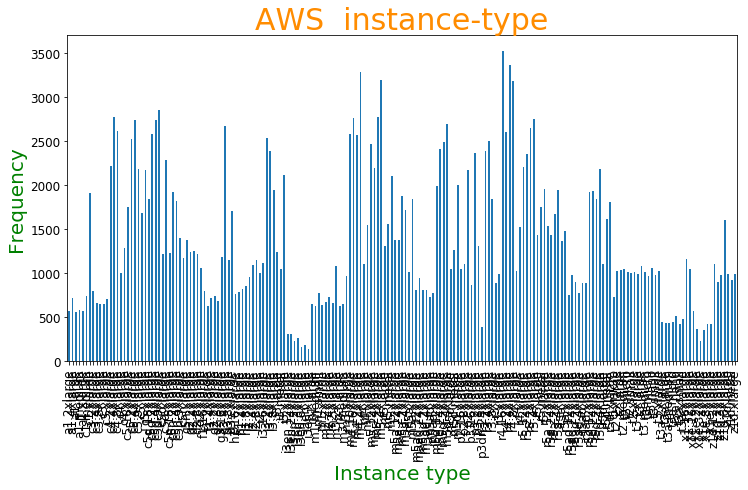

In [44]:
s=linux_full_dataset.groupby('InstanceType').size().plot("bar",figsize=(12,6),fontsize=12)
s.set_title("AWS  instance-type",color='darkorange',fontsize=30)
s.set_xlabel("Instance type",color='g',fontsize=20)
s.set_ylabel("Frequency",color='g',fontsize=20)

Text(0, 0.5, 'Frequency')

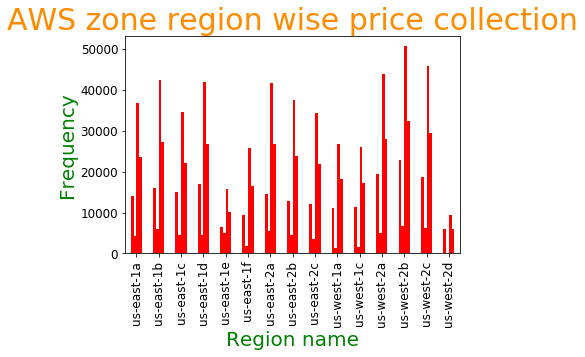

In [45]:
s=linux_full_dataset.groupby('AvailabilityZone').sum().plot(kind="bar",fontsize=12,color='r',legend=False)
s.set_title("AWS zone region wise price collection",color='darkorange',fontsize=30)
s.set_xlabel("Region name",color='g',fontsize=20)
s.set_ylabel("Frequency",color='g',fontsize=20)

In [46]:
linux_full_dataset.sample(2)

,InstanceType,Zone,Timestamp,AvailabilityZone,Price_Linux/UNIX,Memory,vCPUs,GPUs,Cost_linux_ondemand,Cost_linux_reserved
304645,c5d.9xlarge,us-east-2,2019-05-27 05:42:00,us-east-2c,0.3639,72.0,36,0,1.728,1.096
170409,x1e.8xlarge,us-west-2,2019-04-08 16:42:21,us-west-2b,2.0016,976.0,32,0,6.672,4.112


In [47]:
linux_full_dataset['AvailabilityZone_code'] = pd.Categorical(linux_full_dataset['AvailabilityZone']).codes
linux_full_dataset['InstanceType_code'] = pd.Categorical(linux_full_dataset['InstanceType']).codes

In [48]:
linux_full_dataset.sample(3)

,InstanceType,Zone,Timestamp,AvailabilityZone,Price_Linux/UNIX,Memory,vCPUs,GPUs,Cost_linux_ondemand,Cost_linux_reserved,AvailabilityZone_code,InstanceType_code
313559,d2.xlarge,us-east-1,2019-05-29 12:54:00,us-east-1f,0.2070,30.5,4,0,0.6900,0.402,5,38
97720,p2.16xlarge,us-west-2,2019-04-22 08:31:54,us-west-2b,9.2382,768.0,64,16,14.4000,9.828,12,113
295968,t2.2xlarge,us-west-1,2019-05-26 19:41:00,us-west-1c,0.1325,32.0,8,0,0.4416,0.321,10,158


In [49]:
linux_full_dataset['diff_spot_reser']=(linux_full_dataset['Cost_linux_reserved']-linux_full_dataset['Price_Linux/UNIX'])

In [2]:
linux_full_dataset['diff_spot_reser'].describe()

NameError: name 'linux_full_dataset' is not defined

In [51]:
# linux_full_dataset.groupby(['InstanceType'], as_index=False)['diff_spot_reser'].mean().sort_values(by='InstanceType')

In [3]:
# linux_full_dataset['Timestamp'].nunique()

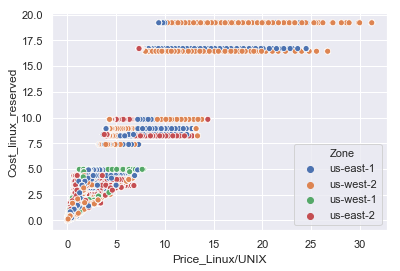

In [52]:
import seaborn as sns; sns.set()
ax = sns.scatterplot(x="Price_Linux/UNIX", y="Cost_linux_reserved",hue="Zone", data=linux_full_dataset)

In [47]:
model_feat.sample(2)

,Timestamp,os_code,vCPU,memory,savings_on_demand,interrupt_freq,Zone_code,InstanceType_code,Price
169378,2019-05-08 07:05:00,0,16.0,128.0,73.0,4.0,2,153,0.3261
121928,2019-04-27 22:53:00,1,36.0,72.0,30.0,3.0,0,20,2.2390


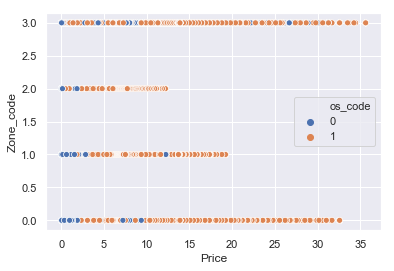

In [48]:
import seaborn as sns; sns.set()
ax = sns.scatterplot(x="Price", y="Zone_code",hue="os_code", data=model_feat)

# BASIC PREP

In [53]:
linux_full_dataset.columns

Index(['InstanceType', 'Zone', 'Timestamp', 'AvailabilityZone',
       'Price_Linux/UNIX', 'Memory', 'vCPUs', 'GPUs', 'Cost_linux_ondemand',
       'Cost_linux_reserved', 'AvailabilityZone_code', 'InstanceType_code',
       'diff_spot_reser'],
      dtype='object')

In [54]:
test_lin = linux_full_dataset[['Timestamp', 'Price_Linux/UNIX', 'Memory', 'vCPUs', 'GPUs', 
                               'Cost_linux_ondemand','Cost_linux_reserved', 'InstanceType_code', 'AvailabilityZone_code']].drop_duplicates()

print(test_lin.shape)
test_lin.sample(2)

(260861, 9)


,Timestamp,Price_Linux/UNIX,Memory,vCPUs,GPUs,Cost_linux_ondemand,Cost_linux_reserved,InstanceType_code,AvailabilityZone_code
195231,2019-05-11 04:04:00,0.3562,32.0,16,0,0.7680,0.484,25,3
249881,2019-05-02 16:42:00,0.1114,32.0,8,0,0.3712,0.230,158,5


In [50]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [52]:
# test_lin.sample(2)

In [57]:
print("MAX TIME:", test_lin.Timestamp.max())
print("MIN TIME:", test_lin.Timestamp.min())

MAX TIME: 2019-05-30 12:16:28
MIN TIME: 2019-03-30 11:00:00


In [58]:
test_lin.columns

Index(['Timestamp', 'Price_Linux/UNIX', 'Memory', 'vCPUs', 'GPUs',
       'Cost_linux_ondemand', 'Cost_linux_reserved', 'InstanceType_code',
       'AvailabilityZone_code'],
      dtype='object')

In [59]:
test_lin = test_lin.sort_values('Timestamp')

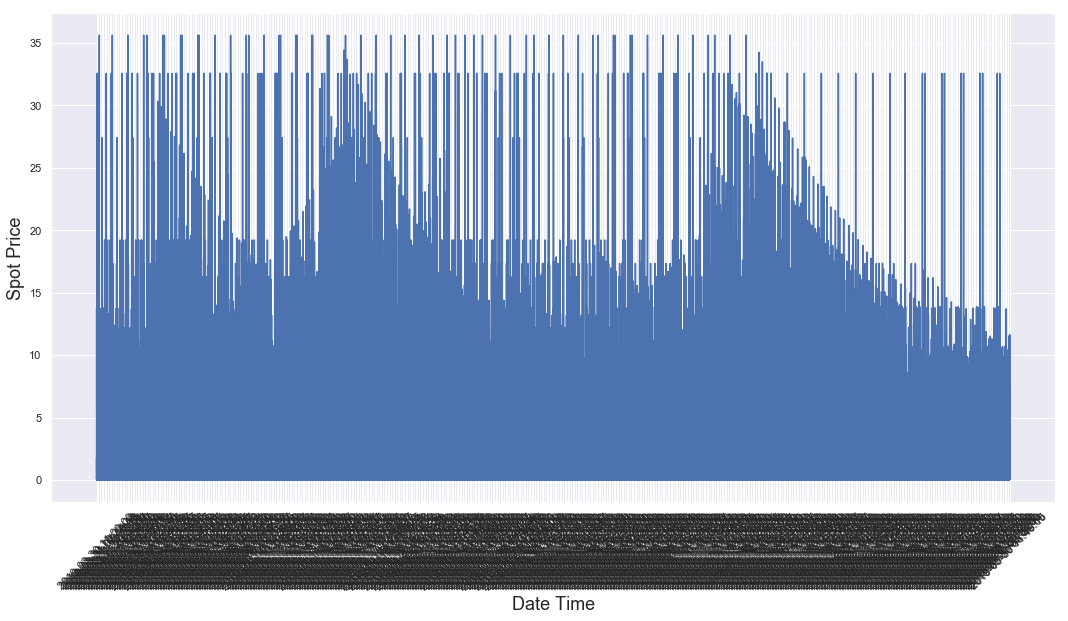

In [55]:
plt.figure(figsize = (18,9))
plt.plot(range(model_feat.shape[0]),(model_feat['Price']))
plt.xticks(range(0,model_feat.shape[0],500),model_feat['Timestamp'].loc[::500],rotation=45)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('Spot Price',fontsize=18)
plt.show()

In [56]:
Spot_Price = model_feat.loc[:,'Price'].as_matrix()
train_data = Spot_Price[:1100]
test_data = Spot_Price[1100:]

In [57]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [58]:
# # Train the Scaler with training data and smooth data
smoothing_window_size = 11000
for di in range(0,11000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])
    
    
# # You normalize the last bit of remaining data
# scaler.fit(train_data[di+smoothing_window_size:,:])
# train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [59]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [60]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1100):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [61]:
import time
from datetime import datetime, date, time, timedelta
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
#         date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
        date = dt.datetime.strptime('Date_Time', '%Y-%m-%d %H:%M:%S').date() + dt.timedelta(days=1)
    else:
        date = model_feat.loc[:,'Timestamp']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00038


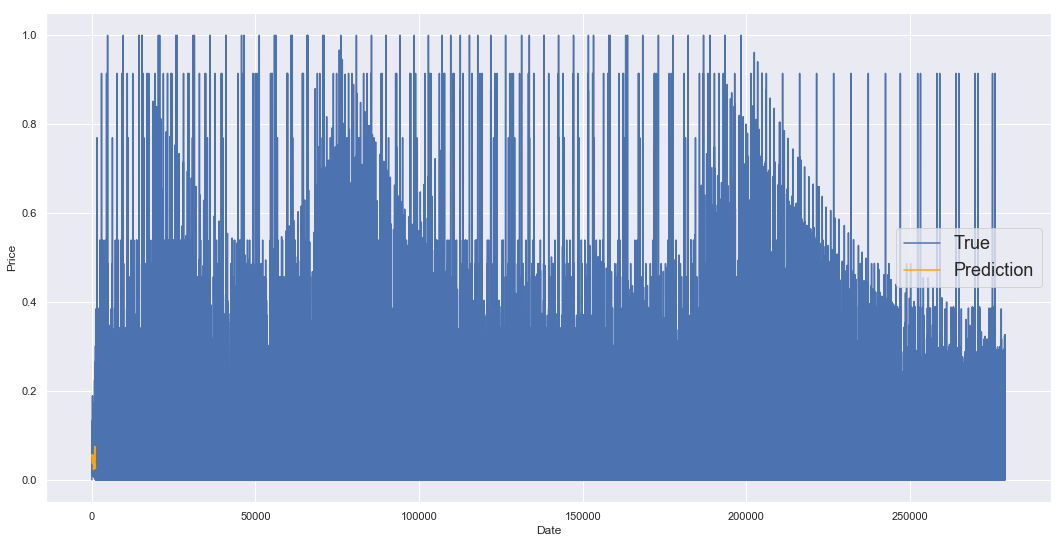

In [62]:
plt.figure(figsize = (18,9))
plt.plot(range(model_feat.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fontsize=18)
plt.show()

In [63]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00008


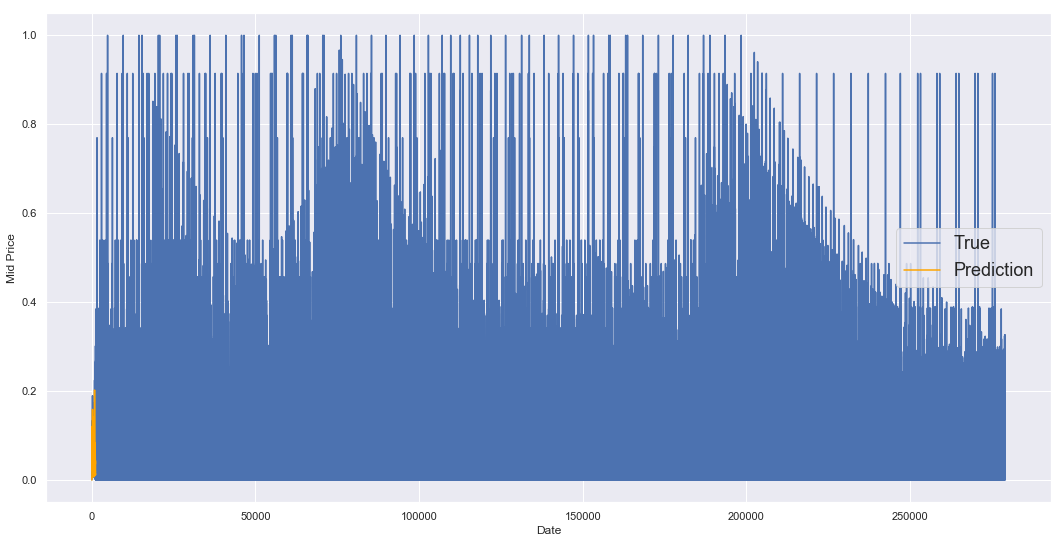

In [64]:
plt.figure(figsize = (18,9))
plt.plot(range(model_feat.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# LSTM

- https://www.datacamp.com/community/tutorials/lstm-python-stock-market

In [49]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))

In [66]:
# train_data

In [71]:
dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00067093 0.02909584 0.00437126 0.10440919 0.03643211]

	Output: [0.00273363 0.02146235 0.00325155 0.0726557  0.03659794]


Unrolled index 1
	Inputs:  [0.00127477 0.02798437 0.00413471 0.0958311  0.03651939]

	Output: [0.00273363 0.02378831 0.00392182 0.08892499 0.03651939]


Unrolled index 2
	Inputs:  [0.00204379 0.02637272 0.00392182 0.08892499 0.03659794]

	Output: [0.00273363 0.03340885 0.0026782  0.06581531 0.03659794]


Unrolled index 3
	Inputs:  [0.00204126 0.02378831 0.00356904 0.08025613 0.03666863]

	Output: [0.00249428 0.03340885 0.0029658  0.0726557  0.03673226]


Unrolled index 4
	Inputs:  [0.00273363 0.02146235 0.00325155 0.0726557  0.03673226]

	Output: [0.00273363 0.0397975  0.00241935 0.06581531 0.03673226]


In [72]:
# from pandas_datareader import data
import urllib.request, json
import os
import numpy.core.multiarray
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [73]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [74]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [75]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [76]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [77]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [78]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [ ]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(1100,1200,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
    
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')
#     session.close()

Initialized


In [69]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(m4_windows.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xlim(1100,1250)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(m4_windows.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.xlim(1100,1250)
plt.show()

In [71]:
model_feat.sample(2)

,Timestamp,os_code,vCPU,memory,savings_on_demand,interrupt_freq,Zone_code,InstanceType_code,Price
141158,2019-05-02 04:30:00,1,8.0,32.0,29.0,2.0,0,96,0.5040
2591,2019-03-31 13:42:45,0,16.0,64.0,65.0,2.0,0,84,0.3129


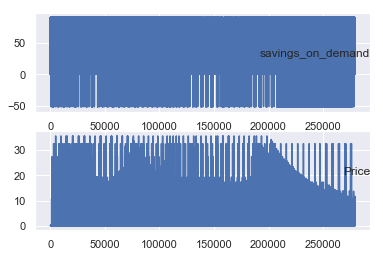

In [74]:
# from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = model_feat.copy()#read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [4,8]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

# ANOTHER METHODS APPROACHABLE

In [75]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# load dataset
# test_lin_1 = test_lin[['Timestamp', 'Price_Linux/UNIX', 'Memory', 'vCPUs', 'GPUs',
#                        'Cost_linux_ondemand', 'Cost_linux_reserved', 'InstanceType_code',
#                        'AvailabilityZone_code']]
dataset = model_feat.set_index('Timestamp')
# dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0   0.007874   0.003971   0.366197   0.000235   0.666667   
2        0.0   0.023622   0.003971   0.866197   0.000000   0.666667   
3        1.0   0.023622   0.007685   0.802817   0.000000   0.666667   
4        0.0   0.023622   0.007685   0.859155   0.000000   0.666667   
5        0.0   0.007874   0.001921   0.901408   0.000000   0.666667   

   var7(t-1)  var8(t-1)  var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.989583   0.000000      0.0  0.023622  0.003971  0.866197  0.000000   
2   0.484375   0.000003      1.0  0.023622  0.007685  0.802817  0.000000   
3   0.286458   0.000033      0.0  0.023622  0.007685  0.859155  0.000000   
4   0.286458   0.000050      0.0  0.007874  0.001921  0.901408  0.000000   
5   0.572917   0.000046      1.0  0.023622  0.003971  0.640845  0.000313   

    var6(t)   var7(t)   var8(t)  
1  0.666667  0.484375  0.000003  
2  0.666667  0.286458  0.000033  
3  0.666667  0

In [77]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 480 #change this to change train and test dataset
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(175200, 1, 15) (175200,) (80696, 1, 15) (80696,)


In [ ]:
# design network
# from keras.utils.visualize_util import to_graph
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM

model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 175200 samples, validate on 80696 samples
Epoch 1/10


In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# WEB SCRAPING MAYBE FOR LATER

In [ ]:
# import boto3
# client = boto3.client('ec2', region_name='us-west-2', aws_access_key_id='',aws_secret_access_key='')

# regions = [x["RegionName"] for x in client.describe_regions()["Regions"]]

# INSTANCE = ['p2.xlarge','c3.8xlarge','m4.2xlarge']
# print("Instance: %s" % INSTANCE)

# results = []

# for region in regions:
#     prices = client.describe_spot_price_history(
#         InstanceTypes=INSTANCE,
#         ProductDescriptions=['Linux/UNIX', 'Windows'],
#         StartTime=(datetime.datetime.now() - datetime.timedelta(days=90)).isoformat(),
#         MaxResults=123
#     )

#     for price in prices["SpotPriceHistory"]:
#         results.append((price["AvailabilityZone"], price["SpotPrice"],price['InstanceType'], price['ProductDescription'], price['Timestamp']))

        
# # 3 regions (us-east-1, us-west-2, eu-west-1)
# # 10 types of instances
# # 2 OS



In [ ]:
# test = pd.DataFrame(results)
# cols = ['AvailabilityZone','SpotPrice','InstanceType','ProductDescription','Timestamp']
# test.columns = cols

In [ ]:
# test.head()

# ANOTHER APPROACH USING https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679